In [168]:
import pandas as pd
import numpy as np
data_rfe=pd.read_csv('norm_shanxi.csv')
data_rfe=np.array(data_rfe)
fea=data_rfe[:,:49]
target=data_rfe[:,49]
x_test=fea[:170,:]
y_test=target[:170]
x_train=fea[170:,:]
y_train=target[170:]

# SVM-RFE_RELIEF

In [169]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_relief_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,alpha,folds):
        #kf=KFold(n_splits=folds,shuffle=False)
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,x_train,y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,x_train,y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            #print(relief_score)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
    def sele_feature(self,alpha,optim_featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        i=featu_num
        while True:
            if len(candi_fea)==optim_featur_num:
                return candi_fea
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(i)
            i-=1

In [170]:
rfe_relief_model=rfe_relief_SVM(x_train,y_train,0.65,0.15)

In [171]:
aver_mean_lis1,F_measure_lis1=rfe_relief_model.featu_score(0.15,5)
print(aver_mean_lis1,F_measure_lis1)

[0.5068936270160238, 0.7631491727125633, 0.7677410094472572, 0.7641708857456027, 0.7611057466464847, 0.763658071924422, 0.7585534213685474, 0.7539602797640795, 0.7549767733180228, 0.7478339161751657, 0.7396589070410772, 0.7304791481810116, 0.7330314734589488, 0.7319993214677176, 0.7274048749934756, 0.7228143431285556, 0.7212863406232058, 0.7182225063938619, 0.7187274909963985, 0.7182264210031839, 0.7177109974424553, 0.7166879795396419, 0.7136254501800721, 0.7075016963307063, 0.6962628529672739, 0.6891147763453207, 0.6840114306592202, 0.681452581032413, 0.6768581345581711, 0.6763479304765385, 0.67277650190511, 0.6620609113210502, 0.6661425439741114, 0.6630774048749934, 0.6589944673521582, 0.6538859021869616, 0.6503131687457592, 0.64316639699358, 0.6411255806670495, 0.6395897489430554, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.623669491937765, 0.77661

In [172]:
aver_mean_lis2,F_measure_lis2=rfe_relief_model.featu_score(0.25,5)
print(aver_mean_lis2,F_measure_lis2)

[0.5068936270160238, 0.7631491727125633, 0.7677410094472572, 0.7641708857456027, 0.7611057466464847, 0.763658071924422, 0.7585534213685474, 0.7539602797640795, 0.7549767733180228, 0.7478339161751657, 0.7396589070410772, 0.7304791481810116, 0.7330314734589488, 0.7319993214677176, 0.7274048749934756, 0.7228143431285556, 0.7212863406232058, 0.7182225063938619, 0.7187274909963985, 0.7182264210031839, 0.7177109974424553, 0.7166879795396419, 0.7136254501800721, 0.7075016963307063, 0.6962628529672739, 0.6891147763453207, 0.6840114306592202, 0.681452581032413, 0.6768581345581711, 0.6763479304765385, 0.67277650190511, 0.6620609113210502, 0.6661425439741114, 0.6630774048749934, 0.6589944673521582, 0.6538859021869616, 0.6503131687457592, 0.64316639699358, 0.6411255806670495, 0.6395897489430554, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.623669491937765, 0.77661

In [173]:
aver_mean_lis3,F_measure_lis3=rfe_relief_model.featu_score(0.35,5)
print(aver_mean_lis3,F_measure_lis3)

[0.5068936270160238, 0.7631491727125633, 0.7677410094472572, 0.7641708857456027, 0.7611057466464847, 0.763658071924422, 0.7585534213685474, 0.7539602797640795, 0.7549767733180228, 0.7478339161751657, 0.7396589070410772, 0.7304791481810116, 0.7330314734589488, 0.7319993214677176, 0.7274048749934756, 0.7228143431285556, 0.7212863406232058, 0.7182225063938619, 0.7187274909963985, 0.7182264210031839, 0.7177109974424553, 0.7166879795396419, 0.7136254501800721, 0.7075016963307063, 0.6962628529672739, 0.6891147763453207, 0.6840114306592202, 0.681452581032413, 0.6768581345581711, 0.6763479304765385, 0.67277650190511, 0.6620609113210502, 0.6661425439741114, 0.6630774048749934, 0.6589944673521582, 0.6538859021869616, 0.6503131687457592, 0.64316639699358, 0.6411255806670495, 0.6395897489430554, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.623669491937765, 0.77661

In [174]:
aver_mean_lis4,F_measure_lis4=rfe_relief_model.featu_score(0.45,5)
print(aver_mean_lis4,F_measure_lis4)

[0.5068936270160238, 0.7631491727125633, 0.7677410094472572, 0.7641708857456027, 0.7611057466464847, 0.763658071924422, 0.7585534213685474, 0.7539602797640795, 0.7549767733180228, 0.7478339161751657, 0.7396589070410772, 0.7304791481810116, 0.7330314734589488, 0.7319993214677176, 0.7274048749934756, 0.7228143431285556, 0.7212863406232058, 0.7182225063938619, 0.7187274909963985, 0.7182264210031839, 0.7177109974424553, 0.7166879795396419, 0.7136254501800721, 0.7075016963307063, 0.6962628529672739, 0.6891147763453207, 0.6840114306592202, 0.681452581032413, 0.6768581345581711, 0.6763479304765385, 0.67277650190511, 0.6620609113210502, 0.6661425439741114, 0.6630774048749934, 0.6589944673521582, 0.6538859021869616, 0.6503131687457592, 0.64316639699358, 0.6411255806670495, 0.6395897489430554, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.623669491937765, 0.77661

In [175]:
aver_mean_lis5,F_measure_lis5=rfe_relief_model.featu_score(0.55,5)
print(aver_mean_lis5,F_measure_lis5)

[0.5068936270160238, 0.7631491727125633, 0.7677410094472572, 0.7641708857456027, 0.7611057466464847, 0.763658071924422, 0.7585534213685474, 0.7539602797640795, 0.7549767733180228, 0.7478339161751657, 0.7396589070410772, 0.7304791481810116, 0.7330314734589488, 0.7319993214677176, 0.7274048749934756, 0.7228143431285556, 0.7212863406232058, 0.7182225063938619, 0.7187274909963985, 0.7182264210031839, 0.7177109974424553, 0.7166879795396419, 0.7136254501800721, 0.7075016963307063, 0.6962628529672739, 0.6891147763453207, 0.6840114306592202, 0.681452581032413, 0.6768581345581711, 0.6763479304765385, 0.67277650190511, 0.6620609113210502, 0.6661425439741114, 0.6630774048749934, 0.6589944673521582, 0.6538859021869616, 0.6503131687457592, 0.64316639699358, 0.6411255806670495, 0.6395897489430554, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.623669491937765, 0.77661

In [176]:
aver_mean_lis6,F_measure_lis6=rfe_relief_model.featu_score(0.65,5)
print(aver_mean_lis6,F_measure_lis6)

[0.5068936270160238, 0.7631491727125633, 0.7677410094472572, 0.7641708857456027, 0.7611057466464847, 0.763658071924422, 0.7585534213685474, 0.7539602797640795, 0.7549767733180228, 0.7478339161751657, 0.7396589070410772, 0.7304791481810116, 0.7330314734589488, 0.7319993214677176, 0.7274048749934756, 0.7228143431285556, 0.7212863406232058, 0.7182225063938619, 0.7187274909963985, 0.7182264210031839, 0.7177109974424553, 0.7166879795396419, 0.7136254501800721, 0.7075016963307063, 0.6962628529672739, 0.6891147763453207, 0.6840114306592202, 0.681452581032413, 0.6768581345581711, 0.6763479304765385, 0.67277650190511, 0.6620609113210502, 0.6661425439741114, 0.6630774048749934, 0.659500756824469, 0.6538859021869616, 0.6503131687457592, 0.64316639699358, 0.6411255806670495, 0.6395897489430554, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.623669491937765, 0.776612

In [177]:
aver_mean_lis7,F_measure_lis7=rfe_relief_model.featu_score(0.75,5)
print(aver_mean_lis7,F_measure_lis7)

[0.5068936270160238, 0.7631491727125633, 0.7677410094472572, 0.7641708857456027, 0.7611057466464847, 0.763658071924422, 0.7585534213685474, 0.7539602797640795, 0.7549767733180228, 0.7478339161751657, 0.7396589070410772, 0.7304791481810116, 0.7330314734589488, 0.7319993214677176, 0.7274048749934756, 0.7228143431285556, 0.7212863406232058, 0.7182225063938619, 0.7187274909963985, 0.7182264210031839, 0.7177109974424553, 0.7166879795396419, 0.7136254501800721, 0.7075016963307063, 0.6962628529672739, 0.6891147763453207, 0.6840114306592202, 0.681452581032413, 0.6768581345581711, 0.6763479304765385, 0.67277650190511, 0.6620609113210502, 0.6661425439741114, 0.6630774048749934, 0.659500756824469, 0.6538859021869616, 0.6503131687457592, 0.64316639699358, 0.6411255806670495, 0.6395897489430554, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.623669491937765, 0.776612

In [178]:
aver_mean_lis8,F_measure_lis8=rfe_relief_model.featu_score(0.85,5)
print(aver_mean_lis8,F_measure_lis8)

[0.4987329714494493, 0.762127459679524, 0.7672295004958505, 0.7611018320371628, 0.7651886841693198, 0.763658071924422, 0.7631465629730153, 0.750390156062425, 0.7493580040711937, 0.7452789811576805, 0.7401782452111278, 0.7376285296727386, 0.7401756354715799, 0.7340440524035701, 0.7294496059293282, 0.7289407067174697, 0.7258833968369957, 0.7253758024949111, 0.7202646275901665, 0.7177109974424553, 0.7192350853384831, 0.7161712511091393, 0.7105590062111801, 0.7069901873792996, 0.6926914243958453, 0.6875841641004227, 0.6845177201315309, 0.6829831932773109, 0.6809410720810064, 0.6748186231014144, 0.6671616472676026, 0.6666514431859701, 0.6646093219896656, 0.6630787097447675, 0.6589931624823843, 0.6543974111383684, 0.650311863875985, 0.6446983141082521, 0.6411229709275015, 0.6411203611879535, 0.6390795448614228, 0.6339761991753223, 0.6283639542773631, 0.6263218330810585, 0.6237708126728952, 0.624281016754528, 0.6247912208361606, 0.624281016754528, 0.6258116289994259] [0.64323083075191, 0.7726

In [179]:
aver_mean_lis9,F_measure_lis9=rfe_relief_model.featu_score(0.95,5)
print(aver_mean_lis9,F_measure_lis9)

[0.4987329714494493, 0.762127459679524, 0.7672295004958505, 0.7677383997077091, 0.7646784800876872, 0.7677383997077091, 0.7656936687718566, 0.7559997912208362, 0.7544730935852602, 0.7514014301372722, 0.7498682081528264, 0.745785270629991, 0.73863458426849, 0.7309776084346782, 0.728422673417193, 0.7289407067174697, 0.7258833968369957, 0.7207696121927032, 0.7202646275901665, 0.7177109974424553, 0.7192350853384831, 0.7161712511091393, 0.7105590062111801, 0.7069901873792996, 0.6926914243958453, 0.693200323607704, 0.6850318388224855, 0.6845229396106268, 0.6804373923482437, 0.6758468604833238, 0.6656375593715746, 0.6656349496320269, 0.6589905527428364, 0.6610326739391408, 0.6579662299702489, 0.6549076152200011, 0.6508220679576178, 0.6452085181898847, 0.6401038676340102, 0.6390795448614228, 0.6355068114202203, 0.6344864032569549, 0.6283639542773631, 0.6263218330810585, 0.6263218330810585, 0.6268320371626912, 0.6278524453259565, 0.6288741583589957, 0.6258116289994259] [0.64323083075191, 0.7726

In [180]:
np.max(aver_mean_lis1[:10]),np.max(aver_mean_lis2[:10]),np.max(aver_mean_lis3[:10]),np.max(aver_mean_lis4[:10]),np.max(aver_mean_lis5[:10])

(0.7677410094472572,
 0.7677410094472572,
 0.7677410094472572,
 0.7677410094472572,
 0.7677410094472572)

In [181]:
np.max(aver_mean_lis6[:10]),np.max(aver_mean_lis7[:10]),np.max(aver_mean_lis8[:10]),np.max(aver_mean_lis9[:10])

(0.7677410094472572,
 0.7677410094472572,
 0.7672295004958505,
 0.7677383997077091)

In [182]:
np.argmax(aver_mean_lis1[:10])

2

# SVM-RFE

In [183]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,folds):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
   
    def featu_subset(self,featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        while True:
            if len(candi_fea)==featur_num:
                return candi_fea
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                #print(scor_fea)
                rfe_score[k]=scor_fea
                k=k+1     
            #print(rfe_score)
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(1)

In [184]:
rfe_SVM_model=rfe_SVM(x_train,y_train,0.65,0.15)
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis=rfe_SVM_model.featu_score(5)

In [185]:
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis

([0.5068936270160238,
  0.7631491727125633,
  0.7677410094472572,
  0.7641708857456027,
  0.7611057466464847,
  0.763658071924422,
  0.7585534213685474,
  0.7539602797640795,
  0.7549767733180228,
  0.7478339161751657,
  0.7396589070410772,
  0.7304791481810116,
  0.7330314734589488,
  0.7319993214677176,
  0.7274048749934756,
  0.7228143431285556,
  0.7212863406232058,
  0.7182225063938619,
  0.7187274909963985,
  0.7182264210031839,
  0.7177109974424553,
  0.7166879795396419,
  0.7136254501800721,
  0.7075016963307063,
  0.6962628529672739,
  0.6891147763453207,
  0.6840114306592202,
  0.681452581032413,
  0.6804321728691476,
  0.6763479304765385,
  0.67277650190511,
  0.6620609113210502,
  0.6661425439741114,
  0.6630774048749934,
  0.6589944673521582,
  0.6579714494493449,
  0.6503131687457592,
  0.64316639699358,
  0.6411255806670495,
  0.6395897489430554,
  0.6390795448614228,
  0.6339761991753223,
  0.6283639542773631,
  0.6263218330810585,
  0.6237708126728952,
  0.624281016754

# SVM-RELIEF

In [186]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class relief_SVM:
    def __init__(self,x_train,y_train,C,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=C
        self.Gamma=gamma
    def featu_score(self,folds):
        kf=KFold(n_splits=folds,shuffle=False)
        featu_num=self.X_train.shape[1]
        relief_fea_score=reliefF.reliefF(self.X_train,self.Y_train)
        relief_candi_fea=list(reliefF.feature_ranking(relief_fea_score))
        aver_lis=[i for i in range(featu_num)]
        F_lis=[i for i in range(featu_num)]
        for i in range(featu_num):
            estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
            candi_fea=relief_candi_fea[:(i+1)]
            aver=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="accuracy",cv=kf,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="f1",cv=kf,n_jobs=-1))
            aver_lis[i]=aver
            F_lis[i]=F1 
        return aver_lis,F_lis

In [187]:
relief_SVM_model=relief_SVM(x_train,y_train,0.65,0.15)
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis=relief_SVM_model.featu_score(5)

In [188]:
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis

([0.7743749673782557,
  0.7820267237329714,
  0.7886776449710319,
  0.7886737303617098,
  0.7886737303617098,
  0.7861227099535466,
  0.7830562659846547,
  0.782546061903022,
  0.7805039407067174,
  0.7850970823111854,
  0.7830588757242027,
  0.7784657341197349,
  0.7769325121352889,
  0.7799885171459888,
  0.7825421472937,
  0.7759016650138315,
  0.7743710527689337,
  0.7723315413121771,
  0.7697766062946918,
  0.7667153818048958,
  0.766714076935122,
  0.766714076935122,
  0.7662051777232632,
  0.7641669711362805,
  0.7595673051829427,
  0.7610979174278407,
  0.7626259199331906,
  0.7575186596377682,
  0.7544561302781982,
  0.7539446213267915,
  0.7513949057884022,
  0.754967639229605,
  0.7539498408058877,
  0.7498669032830524,
  0.7411856046766532,
  0.7294365572315883,
  0.7274009603841536,
  0.7258703481392558,
  0.7207643927136071,
  0.715146928336552,
  0.7125959079283888,
  0.7090244793569601,
  0.6962641578370479,
  0.6947361553316979,
  0.6977973798214937,
  0.67430841901978

D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31616 (\N{CJK UNIFIED IDEOGRAPH-7B80}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UN

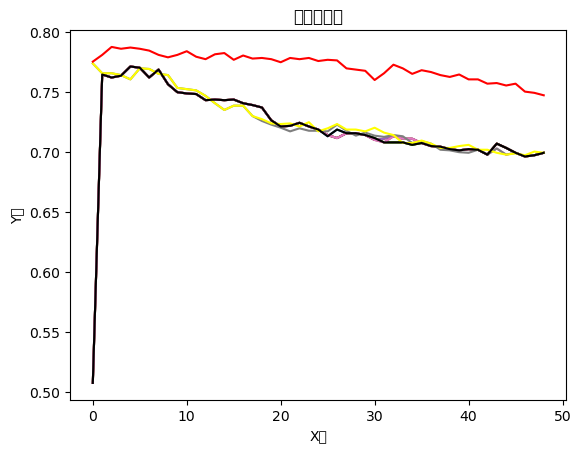

In [85]:
import matplotlib.pyplot as plt

fea_num=[i for i in range(49)]

# 创建图形
plt.plot(fea_num, aver_mean_lis1)
plt.plot(fea_num, aver_mean_lis2)
plt.plot(fea_num, aver_mean_lis3)
plt.plot(fea_num, aver_mean_lis4)
plt.plot(fea_num, aver_mean_lis5)
plt.plot(fea_num, aver_mean_lis6)
plt.plot(fea_num, aver_mean_lis7)
plt.plot(fea_num, aver_mean_lis8)
plt.plot(fea_num, aver_mean_lis9,color="yellow")
plt.plot(fea_num, rfe_SVM_aver_mean_lis,color="black")
plt.plot(fea_num, relief_SVM_aver_mean_lis,color="red")



# 添加标题和标签
plt.title('简单折线图')
plt.xlabel('X轴')
plt.ylabel('Y轴')

# 显示图形
plt.show()


In [201]:
shanxi_accuracy=[]
shanxi_accuracy.append(aver_mean_lis1)
shanxi_accuracy.append(aver_mean_lis2)
shanxi_accuracy.append(aver_mean_lis3)
shanxi_accuracy.append(aver_mean_lis4)
shanxi_accuracy.append(aver_mean_lis5)
shanxi_accuracy.append(aver_mean_lis6)
shanxi_accuracy.append(aver_mean_lis7)
shanxi_accuracy.append(aver_mean_lis8)
shanxi_accuracy.append(aver_mean_lis9)
shanxi_accuracy.append(rfe_SVM_aver_mean_lis)
shanxi_accuracy.append(relief_SVM_aver_mean_lis)

In [202]:
colu=[i for i in range(1,50)]
shanxi_acurracy_dataframe=pd.DataFrame(columns=colu,data=np.array(shanxi_accuracy))
shanxi_acurracy_dataframe.to_csv("shanxi_accuracy.csv")

In [203]:
shanxi_F_measure=[]
shanxi_F_measure.append(F_measure_lis1)
shanxi_F_measure.append(F_measure_lis2)
shanxi_F_measure.append(F_measure_lis3)
shanxi_F_measure.append(F_measure_lis4)
shanxi_F_measure.append(F_measure_lis5)
shanxi_F_measure.append(F_measure_lis6)
shanxi_F_measure.append(F_measure_lis7)
shanxi_F_measure.append(F_measure_lis8)
shanxi_F_measure.append(F_measure_lis9)
shanxi_F_measure.append(rfe_SVM_F_measure_lis)
shanxi_F_measure.append(relief_SVM_F_measure_lis)

In [204]:
colu=[i for i in range(1,50)]
shanxi_F_measure_dataframe=pd.DataFrame(columns=colu,data=np.array(shanxi_F_measure))
shanxi_F_measure_dataframe.to_csv("shanxi_F_measure.csv")